# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    \pi & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.pendulum import InvertedPendulumDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.01
dynamics = InvertedPendulumDynamics(dt)

In [7]:
x_goal = dynamics.augment_state(np.array([np.pi, 0.0]))

Q = np.array([[100.0, 0.0, 0.0], [0.0, 100.0, 0.0], [0.0, 0.0, 1.0]])
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[1.0]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 600

# Note that the augmented state is not all 0.
x0 = dynamics.augment_state(np.array([0.0, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)

iteration 0 accepted 240147.54351 [ 0.11932007 -0.08499769]
iteration 1 accepted 239634.808347 [ 0.22929695 -0.08485151]
iteration 2 accepted 238098.875061 [ 0.42002486 -0.1250911 ]
iteration 3 accepted 233592.253186 [ 0.75950274 -0.15747018]
iteration 4 accepted 221761.50304 [ 1.36232152  0.03940243]
iteration 5 accepted 220466.707646 [ 1.69130258  3.36961509]
iteration 6 accepted 209023.737172 [ 1.44125669  4.02961127]
iteration 7 accepted 207924.212949 [ 0.85228566  5.2109066 ]
iteration 8 accepted 201885.271755 [ 0.21416644  6.15526837]
iteration 9 accepted 194300.69618 [-1.57014414  4.4601512 ]
iteration 10 accepted 180609.773783 [ 3.0281264 -1.0392002]
iteration 11 accepted 178807.585366 [ 2.74919688 -1.86536124]
iteration 12 accepted 177427.080731 [ 2.90453456 -1.56536627]
iteration 13 accepted 176743.772086 [ 2.93436971 -1.87964723]
iteration 14 accepted 174635.175204 [ 2.9823703  -2.10945673]
iteration 15 accepted 174601.726946 [ 3.05359999 -2.51219331]
iteration 16 accepted 1

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

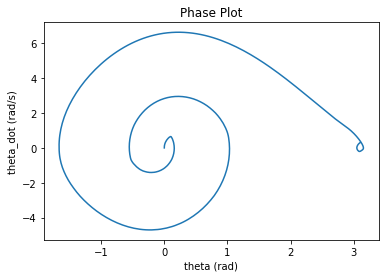

In [12]:
plt.plot(theta, theta_dot)
plt.xlabel("theta (rad)")
plt.ylabel("theta_dot (rad/s)")
plt.title("Phase Plot")

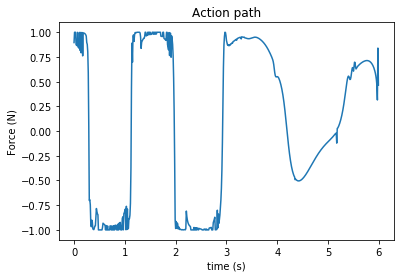

In [13]:
plt.plot(t, us)
plt.xlabel("time (s)")
plt.ylabel("Force (N)")
plt.title("Action path")

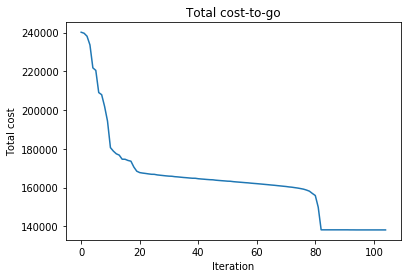

In [14]:
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("Total cost")
plt.title("Total cost-to-go")